In [1]:
#-*- coding=utf-8 -*-
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '../valuate')

import time
import pymysql
import numpy as np
import pandas as pd
import datetime
pd.set_option('precision', 2)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

In [2]:
def cal_accuracy(df):
    ran = 0
    if 0 < df['price'] <= 5000:
        ran = 1000
    elif 5000 < df['price'] <= 20000:
        ran = 2000
    elif 20000 < df['price'] <= 30000:
        ran = 3000
    elif 30000 < df['price'] <= 40000:
        ran = 4000
    elif 40000 < df['price'] <= 100000:
        ran = 5000
    elif 100000 < df['price'] <= 150000:
        ran = 7500
    elif 150000 < df['price'] <= 200000:
        ran = 10000
    elif 200000 < df['price'] <= 300000:
        ran = 15000
    elif 300000 < df['price'] <= 400000:
        ran = 20000
    elif 400000 < df['price'] <= 600000:
        ran = 30000
    elif 600000 < df['price'] <= 800000:
        ran = 40000
    elif 800000 < df['price'] <= 1000000:
        ran = 50000
    elif 1000000 < df['price']:
        ran = df['price'] * 0.05
    
    if (df['price']-ran) <= df['buy_price'] <= (df['price']+ran):
        return 1
    else:
        return 0

def price_category(df):
    if 0 <= df['price'] <= 50000:
        return '0-5万'
    elif 50000 < df['price'] <= 100000:
        return '5-10万'
    elif 100000 < df['price'] <= 200000:
        return '10-20万'
    elif 200000 < df['price'] <= 300000:
        return '20-30万'
    elif 300000 < df['price'] <= 500000:
        return '30-50万'
    elif 500000 < df['price'] :
        return '50万以上'

#                                                   估值验证报告
## 本报告采用以下范围作为二手车的合理预测范围,左:交易价范围 右:预测合理价格范围

In [1]:
print('0-5000元   1000元')
print('5001-20000元 2000元')
print('20001-30000元 3000元')
print('30001-40000元 4000元')
print('40001-100000元 5000元')
print('100001-150000元 7500元')
print('150001-200000元 10000元')
print('200001-300000元 15000元')
print('300001-400000元 20000元')
print('400001-600000元 30000元')
print('600001-800000元 40000元')
print('800001-1000000元 50000元')
print('>100万  5%')

0-5000元   1000元
5001-20000元 2000元
20001-30000元 3000元
30001-40000元 4000元
40001-100000元 5000元
100001-150000元 7500元
150001-200000元 10000元
200001-300000元 15000元
300001-400000元 20000元
400001-600000元 30000元
600001-800000元 40000元
800001-1000000元 50000元
>100万  5%


## 采用车源时间范围:9月-10月， 数据采用自瓜子,人人车,优信三平台

In [4]:
global_model_mean = pd.read_csv('../tmp/global_model_mean.csv')
predict_result = pd.read_csv('../tmp/predict_result.csv')
predict_result = predict_result.loc[(predict_result['created_on'] <= '2018-10-27'), :]
predict_result['accuracy'] = predict_result.apply(cal_accuracy,axis=1)
predict_result['price_category'] = predict_result.apply(price_category,axis=1)
print('本次报告验证覆盖品牌数:',len(set(predict_result.brand_slug.values)), '| 公平价品牌总数:',len(set(global_model_mean.brand_slug.values)))
print('本次报告验证覆盖车系数:',len(set(predict_result.model_slug.values)),'| 公平价车系总数:',len(set(global_model_mean.model_slug.values)))
print('本次报告验证覆盖款型数:',len(set(predict_result.detail_slug.values)),'| 公平价款型总数:',len(set(global_model_mean.detail_slug.values)))
print('本次报告验证所用车源总数:',len(set(predict_result.id.values)))

本次报告验证覆盖品牌数: 119 | 公平价品牌总数: 196
本次报告验证覆盖车系数: 1080 | 公平价车系总数: 1826
本次报告验证覆盖款型数: 12998 | 公平价款型总数: 31455
本次报告验证所用车源总数: 251077


In [5]:
date_node_rate = pd.DataFrame(columns=['node_date','accuracy_rate','num'])

min_date = time.strptime(min(set(predict_result.created_on.values)),"%Y-%m-%d %H:%M:%S")
max_date = time.strptime(max(set(predict_result.created_on.values)),"%Y-%m-%d %H:%M:%S")
min_date = datetime.datetime(min_date[0],min_date[1],min_date[2])
max_date = datetime.datetime(max_date[0],max_date[1],max_date[2])
diff = max_date - min_date
days = diff.days

for i in range(0,int(days/7)+1):
    fan_low = min_date + datetime.timedelta(days=i*7)
    fan_high = min_date + datetime.timedelta(days=(i+1)*7)
    temp = predict_result.loc[(fan_low.strftime('%Y-%m-%d') <= predict_result['created_on']) & (predict_result['created_on'] < fan_high.strftime('%Y-%m-%d')), :].reset_index(drop=True)
    date_node_rate.loc[i, 'node_date'] = fan_high.strftime('%Y-%m-%d')
    date_node_rate.loc[i, 'accuracy_rate'] = len(temp.loc[(temp['accuracy'] == 1), :]) / len(temp)
    date_node_rate.loc[i, 'num'] = len(temp)
date_node_rate['node_date'] = pd.to_datetime(date_node_rate['node_date'])
date_node_rate['node_date'] = date_node_rate['node_date'].apply(lambda x: x.strftime('%m-%d'))

## 一.车商零售价精度展示(b2c)

### 1.整体精度展示
#### 图1:精度展示图(每周一个数据点,Y轴为合理匹配率,X轴为时间节点) 
#### 图2:车源数量展示图(Y轴为车源数量,X轴为时间节点)

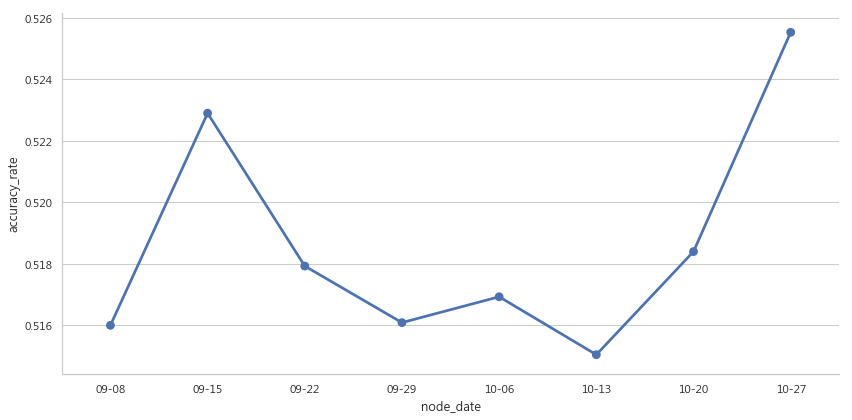

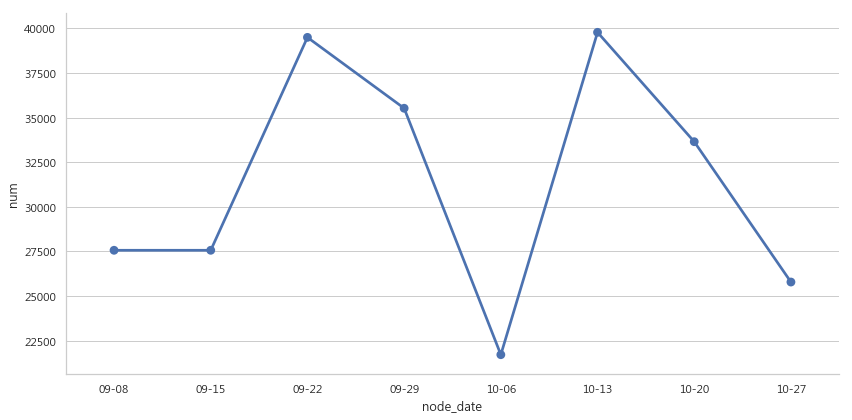

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

im_nums = date_node_rate.loc[:,['node_date','num']]
im_nums = im_nums.drop_duplicates(['node_date','num'])
sns.factorplot(x="node_date", y="accuracy_rate", data=date_node_rate, size=6, aspect=2);  
sns.factorplot(x="node_date", y="num", data=im_nums, size=6, aspect=2); 

### 2.价格分段展示(分成0-5万区间,5-10万区间,10-20万区间,20-30万区间,30-50万区间,50万以上区间)
#### 图1:精度展示图(每周一个数据点,Y轴为合理匹配率,X轴为时间节点) 
#### 图2:车源数量展示图(Y轴为车源数量,X轴为时间节点)

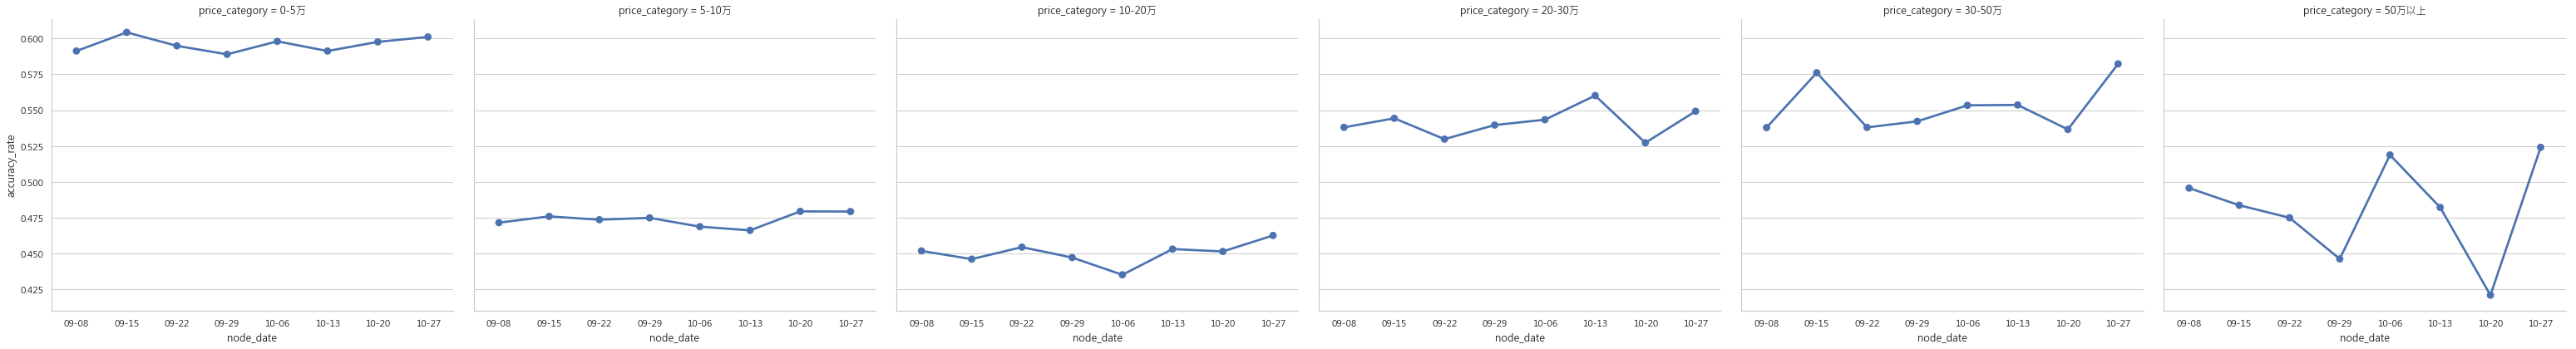

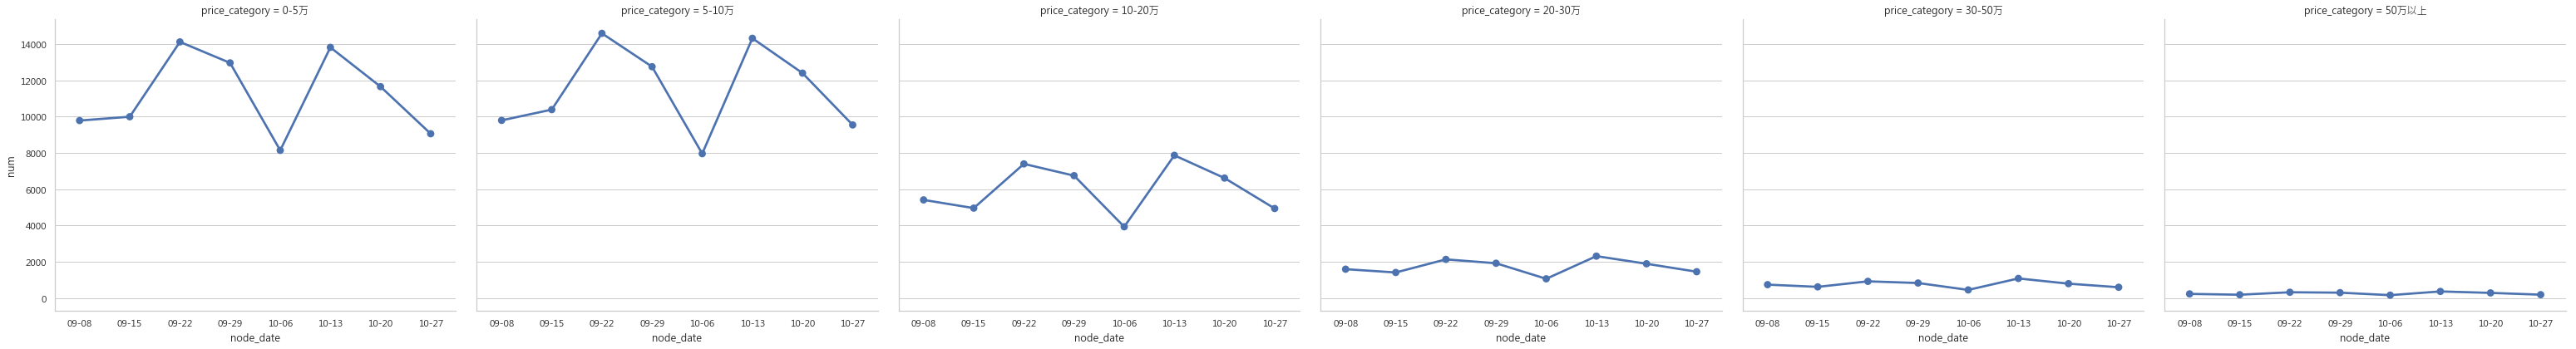

In [7]:
PRICE_CATEGORY = ['0-5万','5-10万','10-20万','20-30万','30-50万','50万以上']
min_date = time.strptime(min(set(predict_result.created_on.values)),"%Y-%m-%d %H:%M:%S")
max_date = time.strptime(max(set(predict_result.created_on.values)),"%Y-%m-%d %H:%M:%S")
min_date = datetime.datetime(min_date[0],min_date[1],min_date[2])
max_date = datetime.datetime(max_date[0],max_date[1],max_date[2])
diff = max_date - min_date
days = diff.days

data = pd.DataFrame()
for price_category in PRICE_CATEGORY:
    temp_date = predict_result.loc[(predict_result['price_category'] == price_category), :].reset_index(drop=True)
    date_node_rate = pd.DataFrame([], columns=['node_date','accuracy_rate','num'])
    for i in range(0,int(days/7)+1):
        fan_low = min_date + datetime.timedelta(days=i*7)
        fan_high = min_date + datetime.timedelta(days=(i+1)*7)
        temp = temp_date.loc[(fan_low.strftime('%Y-%m-%d') <= temp_date['created_on']) & (temp_date['created_on'] < fan_high.strftime('%Y-%m-%d')), :].reset_index(drop=True)
        date_node_rate.loc[i, 'node_date'] = fan_high.strftime('%Y-%m-%d')
        date_node_rate.loc[i, 'accuracy_rate'] = len(temp.loc[(temp['accuracy'] == 1), :]) / len(temp)
        date_node_rate.loc[i, 'num'] = len(temp)
    date_node_rate['price_category'] = price_category
    data = data.append(date_node_rate, sort=False).reset_index(drop=True)
    
    
data['node_date'] = pd.to_datetime(data['node_date'])
data['node_date'] = data['node_date'].apply(lambda x: x.strftime('%m-%d'))
sns.factorplot(x="node_date", y="accuracy_rate",col="price_category", data=data, size=6, aspect=1.2)
sns.factorplot(x="node_date", y="num",col="price_category", data=data, size=6, aspect=1.2)